In [92]:

import numpy as np
from sklearn.preprocessing import MinMaxScaler, RobustScaler
scaler = MinMaxScaler()
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN, LSTM, TimeDistributed, Input, Dropout, GRU
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from keras.saving import register_keras_serializable
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

def create_dataset(dataset, look_back=1, num_predict = 1):
    dataX, dataY = [], []
    for i in range(0, len(dataset)-look_back, num_predict):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + num_predict: i + look_back + num_predict])
    return np.array(dataX), np.array(dataY)

def exponential_moving_average(data, span):
    return data.ewm(span=span, adjust=False).mean()

def read_data(file_path, num_features = 1):
    from pandas import read_csv
    series_influ_A_df = read_csv(file_path, index_col=0, engine='python')
    series_influ_A_df = series_influ_A_df.rename(columns= {"Influenza A - All types of surveillance": "case"})
    series_influ_A_df = series_influ_A_df[["case", "humidity", "temp", "dew","windspeed", "tempmax",][:num_features]]
    return series_influ_A_df.dropna()

def prepare_data(series, look_back, scaler, is_ema = False, num_predict=1):
    if is_ema:
        span = 52  # Bạn có thể điều chỉnh độ dài span tùy ý
        series['case'] = exponential_moving_average(series['case'], span)
    series = series.astype('float32')
    series = series.values
    if scaler is not None:
        flattened_dataset = series.flatten()
        dataset = scaler.fit_transform(flattened_dataset.reshape(-1,1))
        dataset = dataset.reshape(series.shape)

    else: 
        dataset = series

    rest = len(dataset) % look_back
    dataset = dataset[rest:, :]
    trainsize = len(dataset) - look_back
    train = dataset[:trainsize, :]
    test = dataset[trainsize - look_back:, :]

    trainX, trainY = create_dataset(train, look_back, num_predict)
    testX, testY = create_dataset(test, look_back, num_predict)
    return trainX, trainY, testX, testY

def forecast(input, model, num_predict):
    input= np.array([input])
    predicted = model.predict(input, verbose=0)
    return predicted[0][-num_predict:]


def save_plot(x,y, file_path):
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy import stats

    # Generate some sample data
    # x = y_inverse.flatten()
    # y = y_hat_inverse.flatten()

    # Compute the linear regression line
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

    # Create the R-squared line
    r2_line = slope * x + intercept
    r2 = r2_score(x, y)
    r2_pearson = r_value**2
    squared_error = np.square(x-y)

    # Create the scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(x, y, label='Data Points')
    plt.plot(x, squared_error, color='red', marker="o", label=f'squared Error (R²={r2:.2f})')

    # Add labels and title
    plt.xlabel('actual number of infection')
    plt.ylabel('forecast number of infection')
    plt.title('Scatter Plot with R-squared Line')
    plt.legend()
    plt.grid()
    plt.savefig(file_path)
    plt.close()

def inverse_transform(data, scaler):
    flattened_data = data.flatten()
    inverse_flattened_data = scaler.inverse_transform(flattened_data.reshape(-1,1))
    return inverse_flattened_data.reshape(data.shape)

def plot(testY, forecasts):
    import matplotlib.pyplot as plt
    forecastsPlot = forecasts[:,:,0].reshape(-1)
    testPlot = testY[:,:,0].reshape(-1)
    plt.plot(testPlot, "-y", label="actual", marker= '.')
    plt.plot(forecastsPlot, color = 'green',marker='x', label="forecast")
    plt.ylabel("Number of infections")
    plt.legend(["actual", "forecast"])
    plt.show()

In [93]:
def build_model(input_shape, dropout=0.2, dense_units = [], optimizer='adam'):
    model = Sequential()
    model.add(Input(shape=input_shape))

    #Encoder:
    # First LSTM layer with Dropout regularisation
    model.add(LSTM(units=dense_units[0], return_sequences=True))
    model.add(Dropout(dropout))
    # Second LSTM layer
    model.add(LSTM(units=dense_units[1], return_sequences=True))
    model.add(Dropout(dropout))
    # Third LSTM layer
    model.add(LSTM(units=dense_units[2], return_sequences=True))
    model.add(Dropout(dropout))

    #Decoder
    # Fourth LSTM layer
    model.add(LSTM(units=dense_units[2], return_sequences=True))
    model.add(Dropout(dropout))

    model.add(LSTM(units=dense_units[1], return_sequences=True))
    model.add(Dropout(dropout))
    # Fourth LSTM layer
    model.add(LSTM(units=dense_units[0], return_sequences=True))
    model.add(Dropout(dropout))

    model.add(TimeDistributed(Dense(units=input_shape[1], activation='sigmoid' )))
    model.compile(optimizer=optimizer, loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model

In [94]:
df = read_data('../../temp_data/influA_vietnam_last_10_days.csv',num_features=2)
look_back = 10
num_predict = 5
trainX, trainY, testX, testY = prepare_data(df, look_back, scaler, is_ema=True, num_predict = num_predict)

In [95]:
def make_forecasts(test, model, num_predict):
    forecasts = []
    inputStart = test[0]
    inputX = inputStart.reshape(1, inputStart.shape[0], inputStart.shape[1])
    for i in range(len(test)):
        predicted = forecast(inputX[i], model, num_predict)
        forecasts.append(predicted)
        inputXContinue = np.vstack((inputX[-1][- (inputStart.shape[0]-num_predict):], predicted))
        inputX = np.append(inputX, [inputXContinue], axis=0)
    return np.array(forecasts)

In [96]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
model = build_model(
            input_shape=(trainX.shape[1], trainX.shape[2]),
            dense_units=[64,32,16],
            dropout=0.2)
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5)

file_path = 'test.keras'

mc = ModelCheckpoint(file_path, monitor='loss', mode='min', verbose=1, save_best_only=True)
model.fit(trainX, trainY,batch_size=1, callbacks=[es, mc], verbose=0, epochs=200)


Epoch 1: loss improved from inf to 0.03591, saving model to test.keras

Epoch 2: loss improved from 0.03591 to 0.00879, saving model to test.keras

Epoch 3: loss improved from 0.00879 to 0.00529, saving model to test.keras

Epoch 4: loss improved from 0.00529 to 0.00525, saving model to test.keras

Epoch 5: loss improved from 0.00525 to 0.00507, saving model to test.keras

Epoch 6: loss improved from 0.00507 to 0.00500, saving model to test.keras

Epoch 7: loss did not improve from 0.00500

Epoch 8: loss improved from 0.00500 to 0.00498, saving model to test.keras

Epoch 9: loss did not improve from 0.00498

Epoch 10: loss improved from 0.00498 to 0.00492, saving model to test.keras

Epoch 11: loss did not improve from 0.00492

Epoch 12: loss improved from 0.00492 to 0.00488, saving model to test.keras

Epoch 13: loss did not improve from 0.00488

Epoch 14: loss improved from 0.00488 to 0.00487, saving model to test.keras

Epoch 15: loss improved from 0.00487 to 0.00473, saving model 

In [97]:
# i = len(trainX)
# j=0
# print(trainX[i-1], trainY[i-1])
# print("======")
# print(testX[j], testY[j])

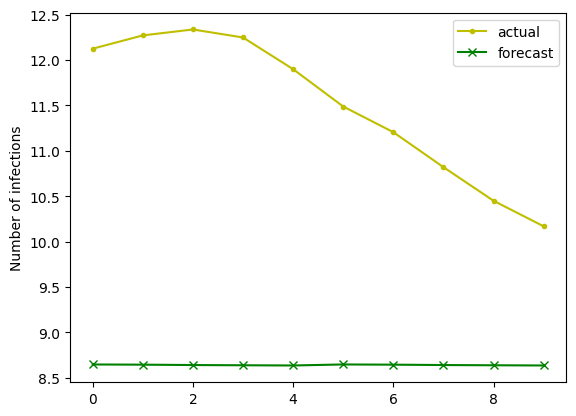

In [98]:
from keras.models import load_model

model = load_model(r"test.keras")
testY_hat = make_forecasts(testX, model, num_predict)
y_hat_inverse = inverse_transform(testY_hat.reshape(1, testY_hat.shape[0] * testY_hat.shape[1], testY_hat.shape[2]), scaler)
y_inverse = inverse_transform(testY[-1].reshape(1,testY[-1].shape[0], testY[-1].shape[1]), scaler)
plot(y_inverse, y_hat_inverse)